In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler

%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SVMSMOTE
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency

from sklearn.metrics import brier_score_loss, fbeta_score, confusion_matrix, precision_recall_curve, auc, make_scorer, precision_score, recall_score

In [2]:
raw = pd.read_csv('dataset/SMU_CodenameJRaw.csv')

In [3]:
codej = pd.read_csv('dataset/SMU_CodenameJRaw.csv')
pd.set_option('display.max_columns', None)

In [4]:
raw.shape

(271488, 58)

In [5]:
codej.columns

Index(['application_xid', 'cdate', 'customer_id', 'product', 'score',
       'province', 'age', 'gender', 'job_type', 'job_industry',
       'last_education', 'marital_status', 'current_loan_status',
       'loan_purpose', 'loan_amount_request', 'loan_duration_request',
       'customer_monthly_income', 'customer_monthly_expense', 'loan_amount',
       'loan_duration', 'loan_disbursement_amount', 'loan_number',
       'start_date_of_loan', 'end_date_of_loan', 'annual_interest_rate',
       'outstanding_principal', 'classification', 'days_past_due',
       'overdue_principal', 'overdue_interest', 'overdue_penalty',
       'accrued_principal', 'accrued_interest', 'accrued_penalty',
       'principal_paid', 'interest_paid', 'penalty_paid',
       'principal_paid_after_wo', 'last_paid_date', 'provision_percentage',
       'provision_fee', 'repayment_schedule', 'write_off_principal',
       'data_date', 'datebin', 'dow_num', 'dow_nm', 'datenum', 'weeknum_mon',
       'monthnum', 'week_start

## Empty, distributions, outliers

In [6]:
null_columns = codej.columns[codej.isnull().any()]
codej[null_columns].isnull().sum()

job_industry                9690
principal_paid                95
interest_paid                 95
penalty_paid                  95
principal_paid_after_wo       95
last_paid_date             23947
dtype: int64

In [7]:
codej = codej.dropna(subset=['job_industry', 'last_paid_date'])

In [8]:
# WO means write off
codej.drop(columns = ['application_xid', 'customer_id', 'cdate', 'outstanding_principal', 'overdue_principal', 'overdue_interest', 'overdue_penalty',
       'accrued_principal', 'accrued_interest', 'accrued_penalty', 'classification',
       'principal_paid', 'interest_paid', 'penalty_paid',
       'principal_paid_after_wo', 'last_paid_date', 'provision_percentage',
       'provision_fee', 'repayment_schedule', 'write_off_principal',
       'data_date', 'datebin', 'dow_num', 'dow_nm', 'datenum', 'weeknum_mon',
       'monthnum', 'week_start_date', 'week_end_date', 'month_start_date',
       'month_end_date', 'yyyy_mm', 'season_yyyy_mm', 'season_dateval',
       'season_dateval_revrs', 'score','current_loan_status', 'loan_duration', 'loan_disbursement_amount', 'start_date_of_loan', 'end_date_of_loan', 'loan_amount', 'annual_interest_rate'], inplace=True)

In [9]:
# 13 + LDR (not in Metadata) + DPD
codej.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239066 entries, 0 to 271459
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   product                   239066 non-null  object 
 1   province                  239066 non-null  object 
 2   age                       239066 non-null  float64
 3   gender                    239066 non-null  object 
 4   job_type                  239066 non-null  object 
 5   job_industry              239066 non-null  object 
 6   last_education            239066 non-null  object 
 7   marital_status            239066 non-null  object 
 8   loan_purpose              239066 non-null  object 
 9   loan_amount_request       239066 non-null  int64  
 10  loan_duration_request     239066 non-null  int64  
 11  customer_monthly_income   239066 non-null  int64  
 12  customer_monthly_expense  239066 non-null  int64  
 13  loan_number               239066 non-null  i

# Target Variable

In [10]:
codej['days_past_due'].value_counts(normalize = True)

0      0.812909
31     0.007479
29     0.005839
59     0.005028
32     0.004940
         ...   
475    0.000004
413    0.000004
347    0.000004
440    0.000004
306    0.000004
Name: days_past_due, Length: 457, dtype: float64

In [11]:
# create a new column based on the loan_status column that will be our target variable
codej['default'] = np.where(codej.loc[:, 'days_past_due'] >= 90, 1, 0)

codej.drop(columns = ['days_past_due'], inplace = True)

In [12]:
codej['default'].value_counts(normalize = True)

0    0.889738
1    0.110262
Name: default, dtype: float64

# EDA

In [13]:
# sns.pairplot(data=codej, x_vars=codej.columns, 
#               y_vars=codej.columns, diag_kind = None)

Customer monthly expense and loan number possible negatively correlated<br>
Customer monthly expense and customer monthly income possibly positively correlated

In [14]:
data_cat = codej.select_dtypes(include = 'object').copy()
data_num = codej.select_dtypes(include = 'number').copy()

## Numerical columns

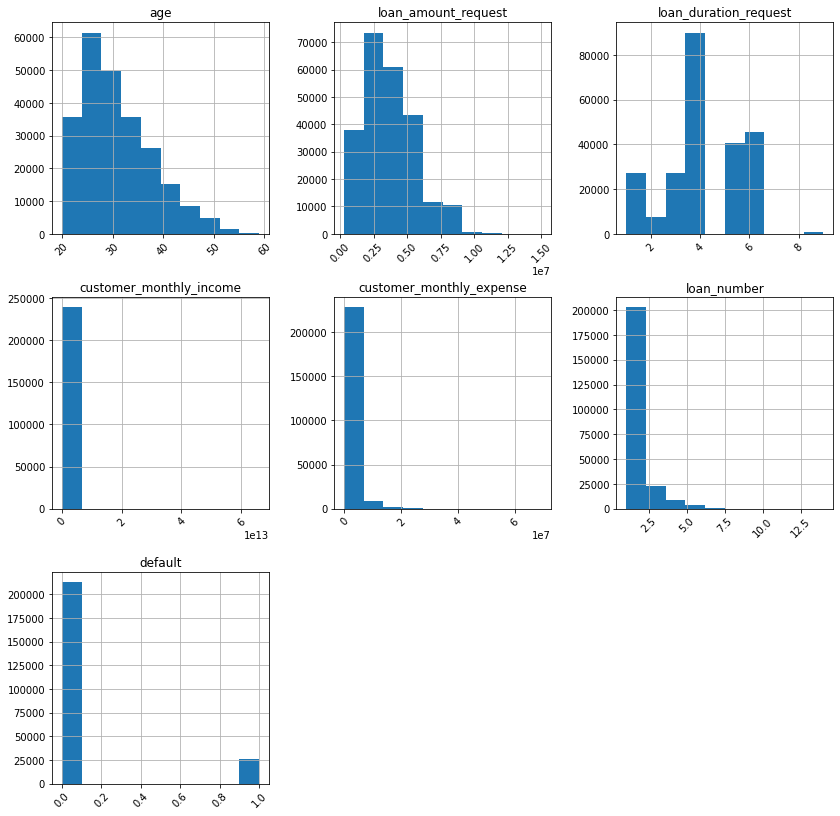

In [15]:
data_num.hist(figsize=(14,14), xrot=45)
plt.show()

Outliers in customer monthly income/expense, loan number, loan duration request

In [16]:
data_num.describe()

,age,loan_amount_request,loan_duration_request,customer_monthly_income,customer_monthly_expense,loan_number,default
count,239066.000000,2.390660e+05,239066.00000,2.390660e+05,2.390660e+05,239066.000000,239066.000000
mean,30.705843,3.613524e+06,4.05209,2.959227e+08,2.617590e+06,1.626149,0.110262
std,7.187960,1.972570e+06,1.51656,1.351484e+11,2.428314e+06,0.997946,0.313217
min,20.000000,3.000000e+05,1.00000,3.339830e+05,0.000000e+00,1.000000,0.000000
25%,25.000000,2.000000e+06,3.00000,3.940973e+06,1.450000e+06,1.000000,0.000000
50%,29.000000,3.500000e+06,4.00000,4.900000e+06,2.000000e+06,1.000000,0.000000
75%,35.000000,5.000000e+06,5.00000,7.000000e+06,3.000000e+06,2.000000,0.000000
max,59.000000,1.500000e+07,9.00000,6.600000e+13,6.929000e+07,14.000000,1.000000


Significant SD in customer monthly income 

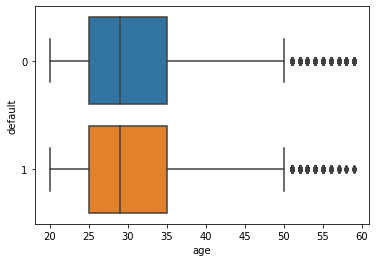

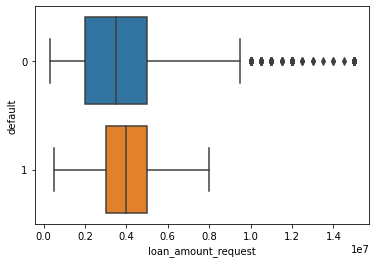

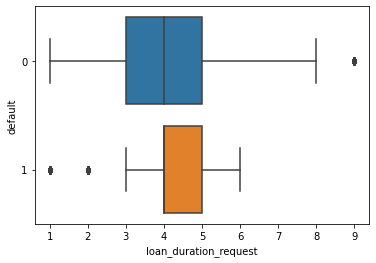

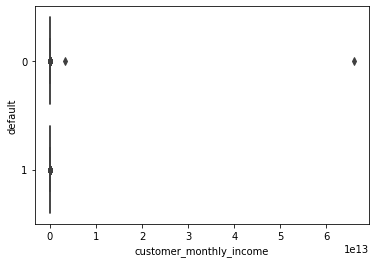

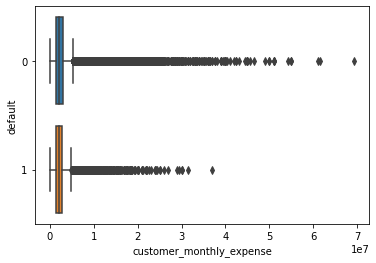

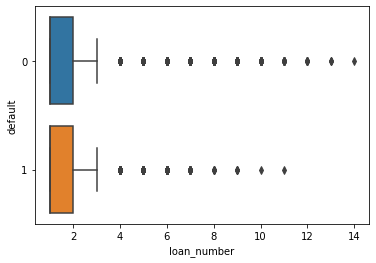

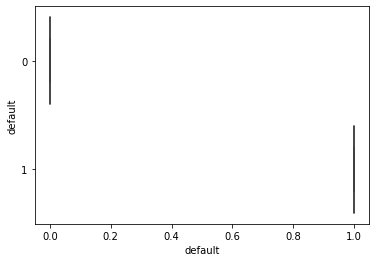

In [17]:
for col in data_num:
    sns.boxplot(y = data_num['default'].astype('category'), x = col, data=codej)
    plt.show()

Most numerical columns seem to not be good predictors<br>
No clear separation between defaults and non-defaults based on range of values <br>
Customer monthly income has distinct outliers <br>
Customer monthly expense has significant spread out outliers <br>

## Categorical columns

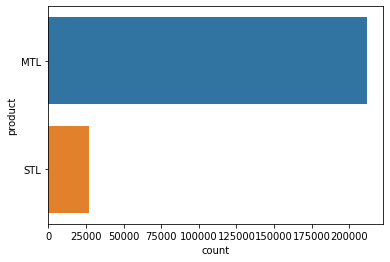

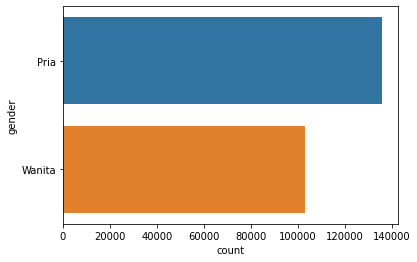

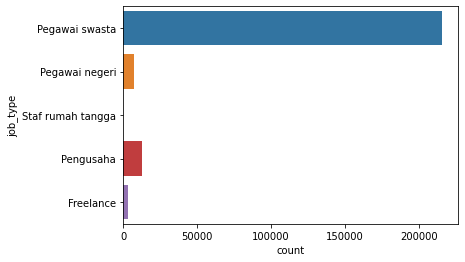

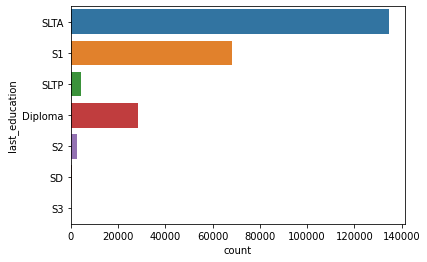

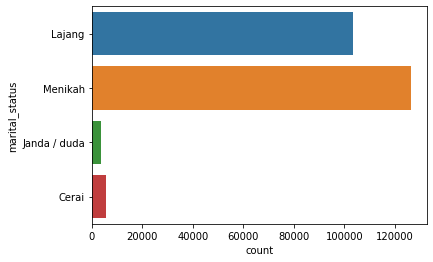

In [18]:
for column in data_cat:
    if data_cat[column].nunique() < 10:
        sns.countplot(y=column, data=data_cat)
        plt.show()

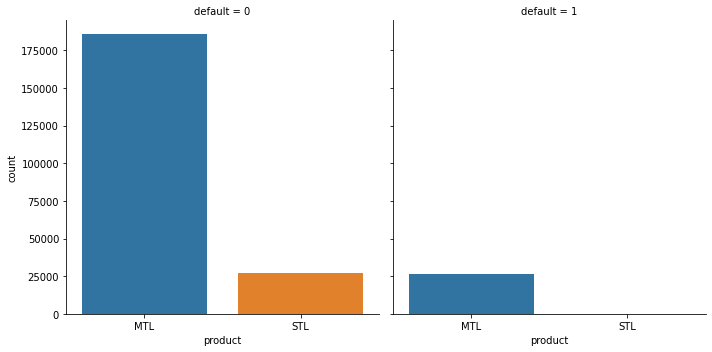

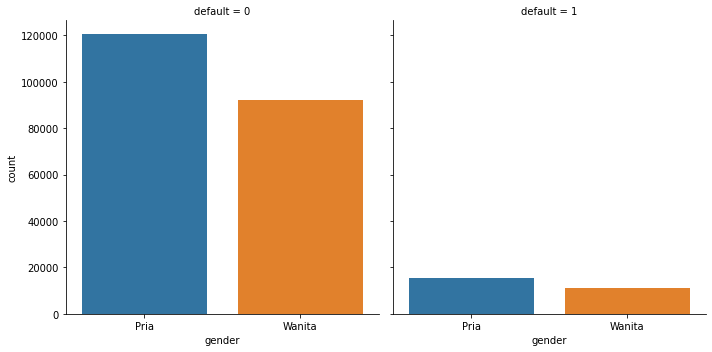

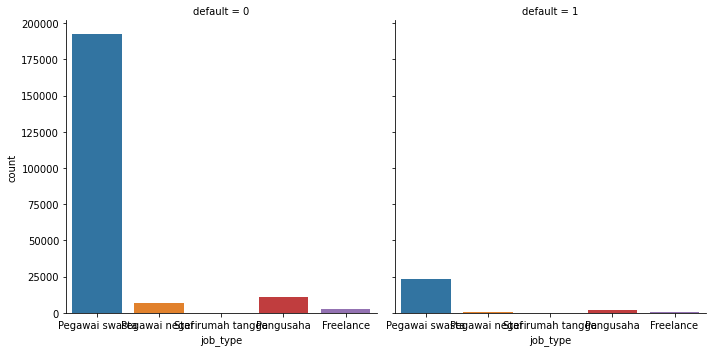

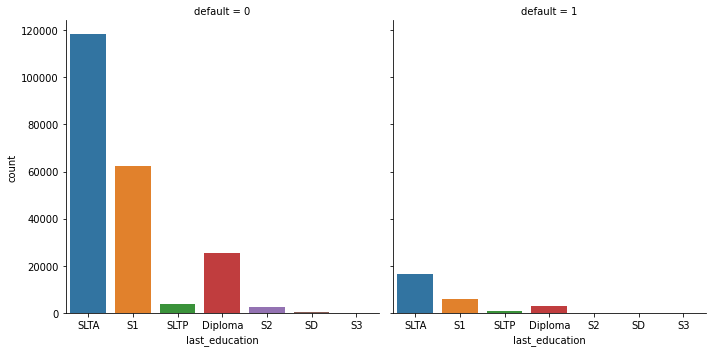

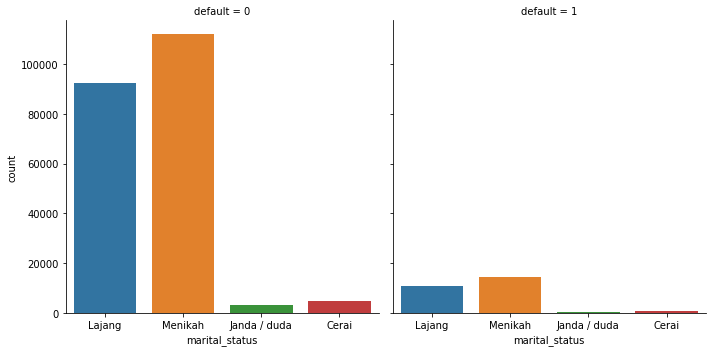

In [19]:
for column in data_cat:
    if data_cat[column].nunique() < 10:
        sns.catplot(x=column, kind='count', col='default', data=codej)
        plt.show()

Product might have a significant difference <br>

## Split Data

In [20]:
X = codej.drop('default', axis = 1)
y = codej['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 2021, stratify = y)

# for experimentation
X_train2, X_test2 = X_train.copy(), X_test.copy()

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239066 entries, 0 to 271459
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   product                   239066 non-null  object 
 1   province                  239066 non-null  object 
 2   age                       239066 non-null  float64
 3   gender                    239066 non-null  object 
 4   job_type                  239066 non-null  object 
 5   job_industry              239066 non-null  object 
 6   last_education            239066 non-null  object 
 7   marital_status            239066 non-null  object 
 8   loan_purpose              239066 non-null  object 
 9   loan_amount_request       239066 non-null  int64  
 10  loan_duration_request     239066 non-null  int64  
 11  customer_monthly_income   239066 non-null  int64  
 12  customer_monthly_expense  239066 non-null  int64  
 13  loan_number               239066 non-null  i

## General Cleaning

In [22]:
codej['loan_number'].value_counts(normalize = True)

1     0.614291
2     0.233684
3     0.095375
4     0.036768
5     0.012779
6     0.004388
7     0.001548
8     0.000657
9     0.000293
10    0.000113
11    0.000059
12    0.000029
13    0.000013
14    0.000004
Name: loan_number, dtype: float64

## Feature Selection

In [23]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

### Chi-Squared Test - Categorical Selection

In [24]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a df
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,product,0.000000
1,job_type,0.000000
2,job_industry,0.000000
3,last_education,0.000000
4,marital_status,0.000000
5,loan_purpose,0.000000
6,gender,0.000007
7,province,0.000280


Chose top 4 categorical features

### ANOVA F-Statistic - Numerical Selection

In [25]:
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,loan_duration_request,802.760809,0.000000e+00
1,loan_amount_request,645.337406,0.000000e+00
2,customer_monthly_expense,370.051878,0.000000e+00
3,loan_number,197.147871,0.000000e+00
4,age,26.614304,2.486000e-07
5,customer_monthly_income,0.136454,7.118327e-01


Ignore customer_monthly_income, not significant

### Pairwise Correlation to detect multicollinearity

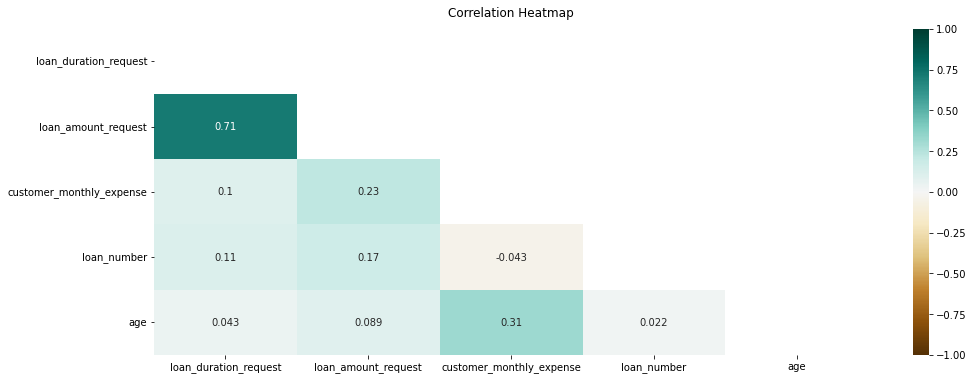

In [26]:
# save the top numerical features that are significant p-value in a list
top_num_features = ANOVA_F_table.iloc[:5,0].to_list()


# calculate pair-wise correlations between them
mask = np.triu(np.ones_like(X_train_num[top_num_features].corr(), dtype=np.bool))

# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(X_train_num[top_num_features].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [27]:
drop_columns_list = ANOVA_F_table.iloc[5:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())

# Could consider dropping
# drop_columns_list.extend(['loan_duration_request',loan_amount_request'])

In [28]:
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

/opt/miniconda3/envs/py3.9/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


only 5 numerical columns remaining

# Create dummy variables

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215159 entries, 210697 to 204122
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   product                   215159 non-null  object 
 1   age                       215159 non-null  float64
 2   job_type                  215159 non-null  object 
 3   job_industry              215159 non-null  object 
 4   last_education            215159 non-null  object 
 5   loan_amount_request       215159 non-null  int64  
 6   loan_duration_request     215159 non-null  int64  
 7   customer_monthly_expense  215159 non-null  int64  
 8   loan_number               215159 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 16.4+ MB


In [30]:
chi2_result.iloc[:4, 0].to_list()

['product', 'job_type', 'job_industry', 'last_education']

In [31]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
X_train = dummy_creation(X_train, chi2_result.iloc[:4, 0].to_list())

## Update Test Data 

In [32]:
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, chi2_result.iloc[:4, 0].to_list())

In [33]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23907 entries, 21417 to 212981
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   product                                  23907 non-null  object 
 1   age                                      23907 non-null  float64
 2   job_type                                 23907 non-null  object 
 3   job_industry                             23907 non-null  object 
 4   last_education                           23907 non-null  object 
 5   loan_amount_request                      23907 non-null  int64  
 6   loan_duration_request                    23907 non-null  int64  
 7   customer_monthly_expense                 23907 non-null  int64  
 8   loan_number                              23907 non-null  int64  
 9   product:MTL                              23907 non-null  uint8  
 10  product:STL                              

In [34]:
# added 4 job industries
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

In [35]:
y_test.value_counts()

0    21271
1     2636
Name: default, dtype: int64

In [36]:
# Drop categorical columns already dummy-ed above
col_to_drop(X_train, chi2_result.iloc[:4, 0])
col_to_drop(X_test, chi2_result.iloc[:4, 0])

In [37]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(215159, 39)
(215159,)
(23907, 39)
(23907,)


## Over-sampling - SVMSMOTE

In [38]:
# BorderlineSMOTE, SVMSMOTE (best performance), ADASYN
oversample = SVMSMOTE()

os_X_train, os_y_train = oversample.fit_resample(X_train, y_train)

## Scaling Data (Standard/Robust Scaler) - Eventually not used

In [ ]:
for col in X_train.columns[:5]:
    print(os_X_train[col].describe())
    print()

In [ ]:
os_scaled_X_train = os_X_train.copy()

In [ ]:
scale_features = X_train.columns[:5]
scaler = StandardScaler()
os_scaled_X_train[scale_features] = scaler.fit_transform(os_scaled_X_train[scale_features])

In [ ]:
for col in X_train.columns[:5]:
    print(os_scaled_X_train[col].describe())
    print()

# PD Models

In [ ]:
def pr_auc(y_true, probas_pred):
    p, r, _ = precision_recall_curve(y_true, probas_pred)
    return auc(r, p)

# TRAINING sets only - Cross-Validation for base model performance 
def evaluate_model(X, y, model):
    cv = StratifiedKFold(n_splits=9, random_state=1, shuffle=True)
    # customised performance measurer
    # metric = make_scorer(pr_auc, needs_proba=True)
    f2 = make_scorer(fbeta_score, beta=2)
    scores = cross_val_score(model, X, y, scoring=f2, cv=cv, n_jobs=-1)
    return scores
 
def get_models():
    models, names = list(), list()
    
    # Logistic Regression
    models.append(LogisticRegression())
    names.append('Logistic Regression')
    # XGB
    models.append(XGBClassifier(objective="binary:logistic", eval_metric="logloss", scale_pos_weight=8, use_label_encoder=False))
    names.append('XGBoost')
    # Stacking XGB -> Logistic Regression
    models.append(StackingClassifier(
    estimators=[('xgb', XGBClassifier(objective="binary:logistic", eval_metric="logloss", scale_pos_weight=8, use_label_encoder=False))], final_estimator=LogisticRegression()))
    names.append('Stacking XGB -> Logistic Regression')
    return models, names

In [ ]:
models, names = get_models()
results = list()

print("Base Model Performance")
for i in range(len(models)):
    scores = evaluate_model(os_X_train, os_y_train, models[i])
    results.append(scores)
    # Average Training (Cross Validated) Scores
    print("Average F2 Measure for Stratified 9-Fold CV")
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
    print()

**Base Model Performance**

Average F2 Measure for 9-Fold CV <br>
**Logistic Regression**: 0.674 (0.002)<br>
**XGBoost**: 0.893 (0.001)<br>
**Stacking XGB with Logistic Regression**: 0.901 (0.002)

PR Plot more info than ROC 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/

## Model 1: Logistic Regression

In [ ]:
logreg = LogisticRegression()

### Hyperparameter tuning Random Search

In [ ]:
f2 = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=9, random_state=1, shuffle=True)

space = dict()
space['solver'] = ['lbfgs', 'liblinear', 'saga']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-4, 1e-3, 1e-2, 1e-1, 1]
space['class_weight'] = ['balanced', None]

search = RandomizedSearchCV(logreg, space, n_iter=120, scoring=f2, n_jobs=-1, cv=cv, random_state=1)

result = search.fit(os_X_train, os_y_train)

print(f"Best Score: {result.best_score_}")
print(f"Best Hyperparameters: {result.best_params_}")

**Logistic Regression Best Model**<br>
Best 9-Fold CV Score: 0.7795259051616399 <br>
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.001, 'class_weight': None }

## Model 2: Extreme Gradient Boosting (XGBoost) 

In [ ]:
xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", tree_method="hist", use_label_encoder=False)

### Hyperparameter tuning Random Search

Common for imbalanced datasets: https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html?highlight=hyparameter%20tuning

In [ ]:
f2 = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=9, random_state=1, shuffle=True)

space = dict()
space['scale_pos_weight'] = [1, 8, 10, 25]
space['gamma'] = [0,0.1,0.2,0.4]
space['subsample'] = [i/10. for i in range(1,6)]

search = RandomizedSearchCV(xgb, space, n_iter=70, scoring=f2, n_jobs=-1, cv=cv, random_state=1)

result = search.fit(os_X_train, os_y_train)

print(f"Best Score: {result.best_score_}")
print(f"Best Hyperparameters: {result.best_params_}")

**XGBoost Best Model**<br>
**Best 9-fold CV Score**: 0.8931866195929639 <br>
**Best Hyperparameters**: {'subsample': 0.5, 'scale_pos_weight': 8, 'gamma': 0.4}

In [ ]:
#Feature importance plot
# fig, (ax1, ax2) = plt.subplots(figsize = (15, 17), ncols=1, nrows=2)
# plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top = 0.9, wspace=0, hspace = 0.5)
# plot_importance(xgb, importance_type='gain', ax = ax1)
# ax1.set_title('Feature Importance by Information Gain', fontsize = 18)
# ax1.set_xlabel('Gain')

### Stacking - Boosting + LR

In [ ]:
# Meta Model Clf
estimators = [('xgb', XGBClassifier(objective="binary:logistic", subsample=0.5, gamma=0.4, scale_pos_weight=8))]
 
metaclf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.001))

print("Best 9-Fold CV Score: ", evaluate_model(os_X_train, os_y_train, metaclf))

In [ ]:
np.mean([0.90319334, 0.90094703, 0.9016386,  0.90230548, 0.90078116, 0.90179997,
 0.89896709, 0.90094899, 0.90237963])

**Stacking Best XGB with Log Reg Best Model**<br>
Best 9-Fold CV Score: 0.9014401433333332 

## Model 3: Multi-Layer Perceptron

In [ ]:
mlp = MLPClassifier(random_state=1)

In [ ]:
print(np.mean(evaluate_model(os_X_train, os_y_train, mlp)))

## Hyperparameter Tuning - Random Search CV

In [ ]:
f2 = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=9, random_state=1, shuffle=True)

# input layer (39) + 1 bias term to output layer (2)
space = {
    'hidden_layer_sizes': [(10,), (21,), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

search = RandomizedSearchCV(mlp, space, n_iter=108, scoring=f2, n_jobs=-1, cv=cv, random_state=1)

result = search.fit(os_X_train, os_y_train)

print(f"Best Score: {result.best_score_}")
print(f"Best Hyperparameters: {result.best_params_}")

**Best CV Score**: 0.8333333333173444 <br>
**Best Hyperparameters**: {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (21,), 'alpha': 0.0001, 'activation': 'relu'}

## Evaluating Models on Test Set 

### Compare F2 Scores, AUPRC, Brier Score

In [39]:
models = {
    'LogisticRegression': LogisticRegression(solver='liblinear', penalty='l1', C=0.001),
    'XGBoost': XGBClassifier(objective="binary:logistic", eval_metric="logloss", subsample=0.5, gamma=0.4, scale_pos_weight=8, use_label_encoder=False),
    'Stacking XGB + Logistic Regr': StackingClassifier(
    estimators=[('xgb', XGBClassifier(objective="binary:logistic", eval_metric="logloss", subsample=0.5, gamma=0.4, scale_pos_weight=8, use_label_encoder=False))], final_estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.001)),
    'Multi-Layer Perceptron': MLPClassifier(solver='lbfgs', learning_rate='constant', hidden_layer_sizes=(21,), alpha=0.0001, activation='relu', random_state=1),
#     'Multi-Layer Perceptron': MLPClassifier(solver='sgd', learning_rate='constant', hidden_layer_sizes=(10,), alpha=0.05, activation='logistic', random_state=1),
}

models_report = pd.DataFrame(columns=['Model', 'F2-Score', 'Precision', 'Recall', 'AUPR', 'Brier Score'])

In [40]:
li = zip(models.values(), models.keys())
for a,b in li:
    print(a)
    print(b)

LogisticRegression(C=0.001, penalty='l1', solver='liblinear')
LogisticRegression
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=0.4, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=8, subsample=0.5, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
XGBoost
StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                      

In [ ]:
for clf, clf_name in zip(models.values(), models.keys()):
    clf.fit(os_X_train, os_y_train)
    yhat = clf.predict(X_test)
    yhat_proba = clf.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, yhat_proba)
    brier = brier_score_loss(y_test, yhat_proba)
    
    data = pd.Series({
        'Model': clf_name,
        'F2-Score': fbeta_score(y_test, yhat, beta=2),
        'Precision': precision_score(y_test, yhat),
        'Recall': recall_score(y_test, yhat),
        'AUPR': auc(recall, precision),
        'Brier Score': brier,
    })
    
    print(data)
    print()
    models_report = models_report.append(data, ignore_index=True)
    
print(models_report)

| Model | F2 | AUPR | Brier Score
| --- | --- | --- | --- |
| Log Regr | 4 | 3 | 2
| XGBoost | 1 | 2 | 3
| Stacking (XGB + Log Regr) | 2 | 2 | 1
| MLP | 3 | 1 | 4

https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4

# Conclusion  

### Get threshold for final chosen model for interpretation

In [40]:
estimators = [('xgb', XGBClassifier(objective="binary:logistic", subsample=0.5, gamma=0.4, scale_pos_weight=8))]
 
metaclf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.001))

metaclf.fit(os_X_train, os_y_train)

/opt/miniconda3/envs/py3.9/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/py3.9/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/py3.9/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/py3.9/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/py3.9/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/py3.9/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=0.4,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, 

## Get final threshold

In [41]:
yhat = metaclf.predict(X_test)
yhat_proba = metaclf.predict_proba(X_test)[:, 1]
    
precision, recall, _ = precision_recall_curve(y_test, yhat_proba)
brier = brier_score_loss(y_test, yhat_proba)

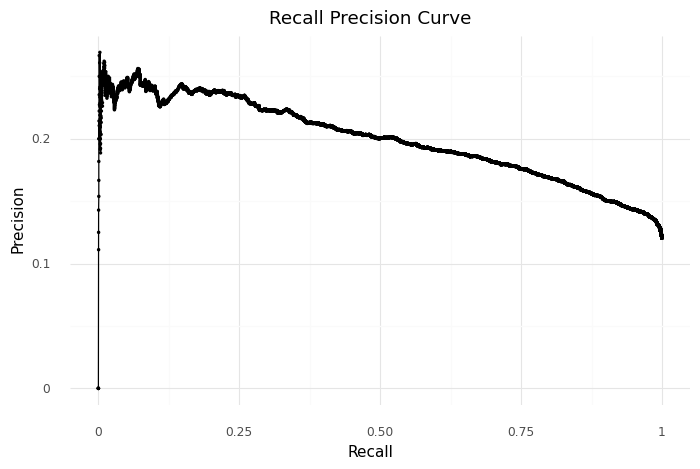

<ggplot: (8770533892898)>

In [42]:
import plotnine
from plotnine import *
# import ggplot

precision, recall, thresholds = precision_recall_curve(y_test, yhat_proba)

# Plot the ROC curve
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# Creat a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)


In [43]:
np.where(recall > 0.5)

(array([    0,     1,     2, ..., 14868, 14869, 14870]),)

In [44]:
print(precision[16418])
print(recall[16418])
print((5 * precision[16418] * recall[16418]) / (4 * precision[16418] + recall[16418]))
print(thresholds[16418])

0.21110210696920584
0.3952959028831563
0.3365633074935401
0.5887448086791108


# Model Explanations

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

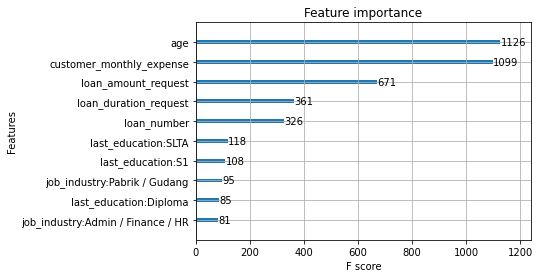

In [77]:
plot_importance(metaclf.estimators_[0], max_num_features=10)

In [112]:
print(metaclf.final_estimator_.coef_)
print(metaclf.final_estimator_.intercept_)

[[5.12758472]]
[-3.66311541]


In [64]:
positive_probas_index = []

for i in range(len(y_test)):
    if y_test.values[i] == 1:
        if yhat[i] == 1:
            print(i)

37
43
66
71
176
192
228
235
247
290
300
309
327
343
362
372
401
403
411
476
485
491
492
499
518
526
553
598
626
673
682
710
712
713
726
767
777
787
792
809
814
823
835
852
861
872
876
898
901
914
956
960
968
1006
1012
1028
1036
1064
1078
1121
1146
1160
1161
1167
1169
1214
1218
1257
1262
1267
1272
1279
1293
1348
1371
1378
1391
1436
1454
1475
1510
1515
1516
1548
1559
1593
1614
1651
1654
1664
1714
1750
1757
1758
1775
1780
1827
1844
1850
1857
1861
1907
1914
1932
1954
1955
1961
2010
2043
2060
2064
2083
2112
2129
2133
2170
2199
2222
2223
2246
2282
2291
2309
2339
2359
2382
2385
2396
2401
2404
2411
2474
2477
2490
2539
2605
2619
2620
2632
2637
2669
2694
2717
2736
2742
2759
2768
2780
2788
2798
2841
2854
2866
2901
2942
2946
2952
2971
3007
3025
3035
3096
3106
3109
3116
3157
3159
3168
3171
3207
3219
3235
3251
3253
3260
3281
3286
3324
3328
3331
3388
3405
3411
3415
3421
3442
3444
3559
3562
3592
3596
3604
3605
3657
3683
3694
3708
3721
3725
3764
3777
3833
3845
3847
3864
3867
3872
3877
3882
3896
3928
39

In [63]:
print(max(yhat_proba))
yhat_proba.tolist().index(0.8081281314233415)

0.8081281314233415


14850

In [54]:
print(largest, index)

1 37


## LIME Explanations

In [47]:
from lime.lime_tabular import LimeTabularExplainer

In [176]:
# https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec
explainer = LimeTabularExplainer(training_data=os_X_train.values, feature_names=os_X_train.columns, class_names=[0,1], mode="classification")
explained = explainer.explain_instance(X_test.values[66], metaclf.predict_proba, num_features=39)
explained.show_in_notebook()

In [68]:
print("True:", y_test.values[66], "--> Pred:", yhat[66], "| Prob:", np.max(yhat_proba[66]))

True: 1 --> Pred: 1 | Prob: 0.6501620246019498


Reference: https://www.garp.org/risk-intelligence/technology/all/a1Z5d000009qxDAEAY

## SHAP Explanations

In [52]:
import shap

In [183]:
metaclf.estimators_[0]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [219]:
explainer = shap.TreeExplainer(metaclf.estimators_[0], data=X_test, model_output="probability")
shap_values = explainer.shap_values(X_test)

100%|===================| 23820/23907 [01:17<00:00]        

## SHAP Summary Plot

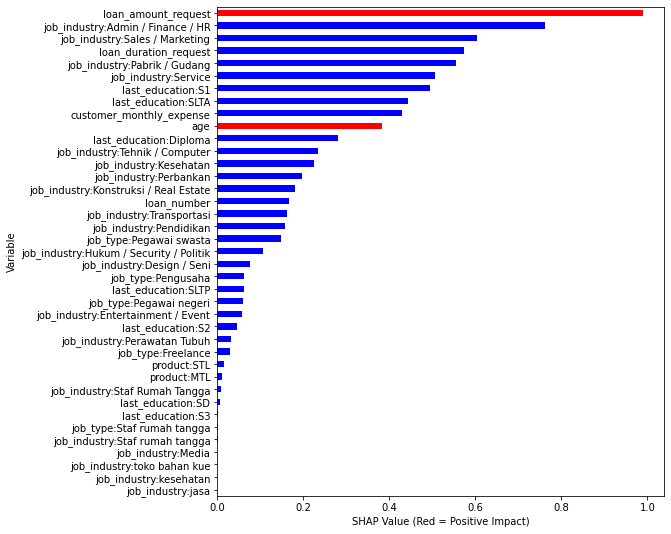

In [115]:
def ABS_SHAP(df_shap,df):
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,9),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_test)

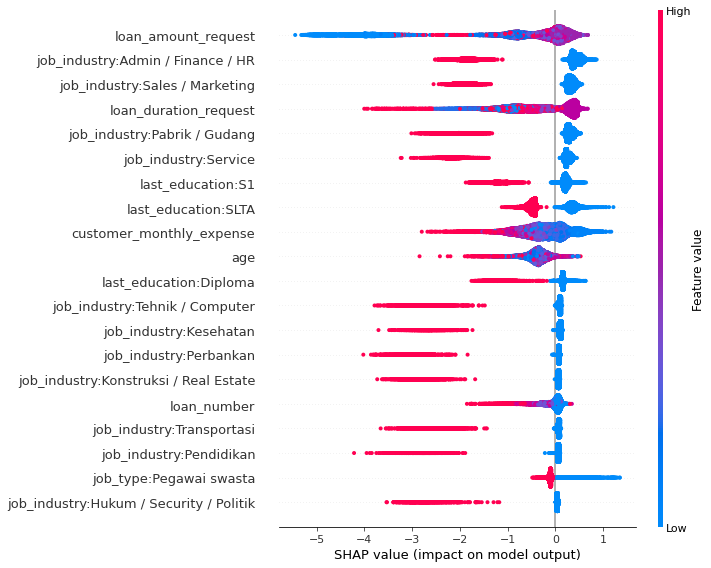

In [103]:
shap.summary_plot(shap_values, X_test)

## SHAP Dependence Plots

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


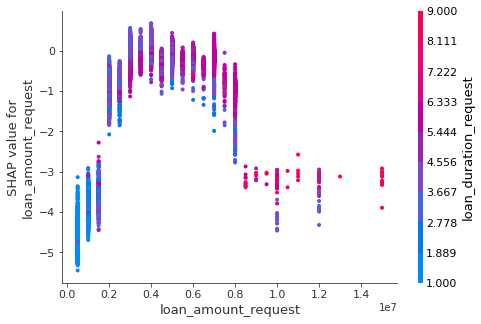

In [119]:
shap.dependence_plot("loan_amount_request", shap_values, X_test)

In [136]:
shap.initjs()

In [146]:
X_train.mean()

age                                        3.071126e+01
loan_amount_request                        3.613636e+06
loan_duration_request                      4.051088e+00
customer_monthly_expense                   2.616142e+06
loan_number                                1.626444e+00
product:MTL                                8.862283e-01
product:STL                                1.137717e-01
job_type:Freelance                         1.411514e-02
job_type:Pegawai negeri                    3.162777e-02
job_type:Pegawai swasta                    9.015798e-01
job_type:Pengusaha                         5.252860e-02
job_type:Staf rumah tangga                 1.487272e-04
job_industry:Admin / Finance / HR          2.354538e-01
job_industry:Design / Seni                 1.524454e-02
job_industry:Entertainment / Event         1.172621e-02
job_industry:Hukum / Security / Politik    2.400550e-02
job_industry:Kesehatan                     4.857338e-02
job_industry:Konstruksi / Real Estate      3.910

In [226]:
def shap_plot(j):
    p = shap.force_plot(shap.TreeExplainer(metaclf.estimators_[0]).expected_value[0], shap_values[j, :], X_test.values[j], feature_names=X_test.columns)
    return(p)

In [228]:
shap_plot(66)

## Confusion Matrix

In [229]:
y_pred = (metaclf.predict_proba(X_test)[:,1] >= 0.52).astype(bool)

In [232]:
cf_matrix = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

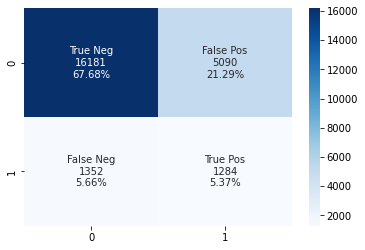

In [236]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

# Future Work

Check integrity of data collection, feature engineering by working with company, build custom credit rating score with weights on each feature. 